# LIGO - Gravitational Waves Detectability

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings

Load **heavily downsampled** data with balanced classes members (Kernel would die using more then 100000 samples...)

In [2]:
y = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\y.npy")

In [3]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\data.npy")

In [4]:
keys = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\LIGO_v2\Npy\keys.npy")

In [121]:
df = pd.DataFrame(data, columns=keys).drop(columns=['snr', 'det'])

In [63]:
X = df.to_numpy()
print('df shape is', X.shape)

df shape is (100000, 13)


## Neural Network for classification

In [64]:
def plot_results(history, title='', log=False):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    if log:
        plt.loglog()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy', linewidth=2)
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=12)
    if log:
        plt.loglog()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Exam\LIGO\NN_results"+f"\{title}"+".png")
    plt.show()

Step one : data standardization + divide in train, validation and test sets

In [65]:
import keras.backend as k
k.clear_session()

In [66]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [67]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

In [68]:
S = RobustScaler()
S.fit(X_train)
X_train = S.transform(X_train)
X_cv = S.transform(X_cv)
X_test = S.transform(X_test)

Now define the architechture of the neural network.\
I got the inspiration from [this](https://arxiv.org/abs/2007.06585) paper by Davide Gerosa, Geraint Pratten, Alberto Vecchio

In [69]:
import tensorflow as tf

class LRTLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)
        
lr_tracker = LRTLogger()

In [70]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [93]:
from sklearn.metrics import roc_auc_score
from keras import regularizers 
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, ReLU, Input, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


model = Sequential([
    Input(shape=(13,)),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform'),
    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
])

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
reduce_lr = LearningRateScheduler(scheduler)
lr_tracker = LRTLogger()
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_cv, y_cv),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, lr_tracker],
    verbose=1
)

Epoch 1/150


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9268 - loss: 0.1663 - val_accuracy: 0.9592 - val_loss: 0.0958 - learning_rate: 0.0100
Epoch 2/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9588 - loss: 0.0929 - val_accuracy: 0.9640 - val_loss: 0.0833 - learning_rate: 0.0100
Epoch 3/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9611 - loss: 0.0856 - val_accuracy: 0.9662 - val_loss: 0.0773 - learning_rate: 0.0100
Epoch 4/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9660 - loss: 0.0812 - val_accuracy: 0.9658 - val_loss: 0.0793 - learning_rate: 0.0100
Epoch 5/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9668 - loss: 0.0778 - val_accuracy: 0.9670 - val_loss: 0.0773 - learning_rate: 0.0100
Epoch 6/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9698 - loss: 0.0711 - val_accuracy: 0.9688 - val_loss: 0.0725 - learning_rate: 0.0100
Epoch 7/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9703 - loss:

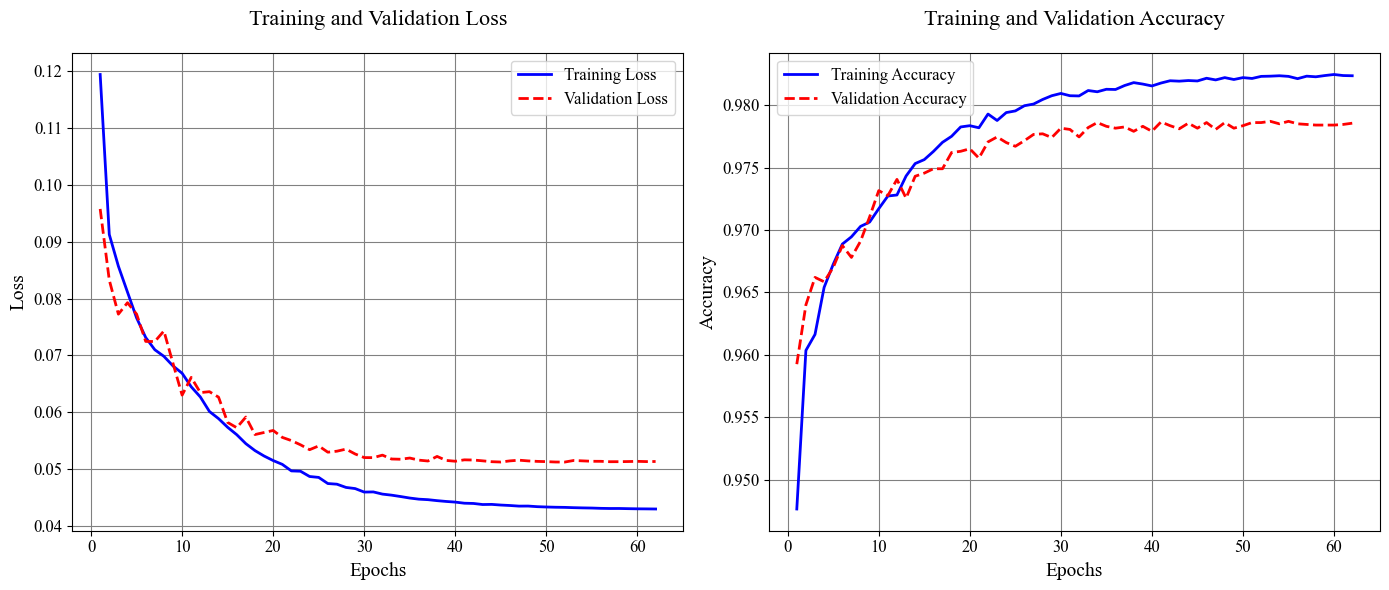

In [74]:
plot_results(history, 'model', log=False)

Observations:
- Training accuracy reaches ~0.982.
- Validation accuracy stabilizes just below (~0.978), suggesting a very small generalization gap.
- Model starts to overfit (I can see it from the gap between training and cv error) around epoch 40. In order to reduce this I can use LASSO regularization

### Model 1

In [94]:
l1_lambda = 1e-4

model1 = Sequential([
    Input(shape=(13,)),
    Dense(32, activation='relu', kernel_initializer='glorot_uniform',
          kernel_regularizer=regularizers.l1(l1_lambda)),
    Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform',
          kernel_regularizer=regularizers.l1(l1_lambda))
])

In [97]:
model1.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']
              )
model1.summary()

lr_tracker1 = LRTLogger()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_cv, y_cv),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, lr_tracker1],
    verbose=1
)

Epoch 1/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9511 - loss: 0.1298 - val_accuracy: 0.9572 - val_loss: 0.1135 - learning_rate: 0.0010
Epoch 2/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9585 - loss: 0.1100 - val_accuracy: 0.9619 - val_loss: 0.1016 - learning_rate: 0.0010
Epoch 3/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9614 - loss: 0.0995 - val_accuracy: 0.9619 - val_loss: 0.0988 - learning_rate: 0.0010
Epoch 4/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9621 - loss: 0.0987 - val_accuracy: 0.9617 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 5/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9624 - loss: 0.0961 - val_accuracy: 0.9628 - val_loss: 0.0964 - learning_rate: 0.0010
Epoch 6/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9627 - loss: 0.0950 - val_accuracy: 0.9635 - val_loss: 0.0940 - learning_rate: 0.0010
Epoch 7/150
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 

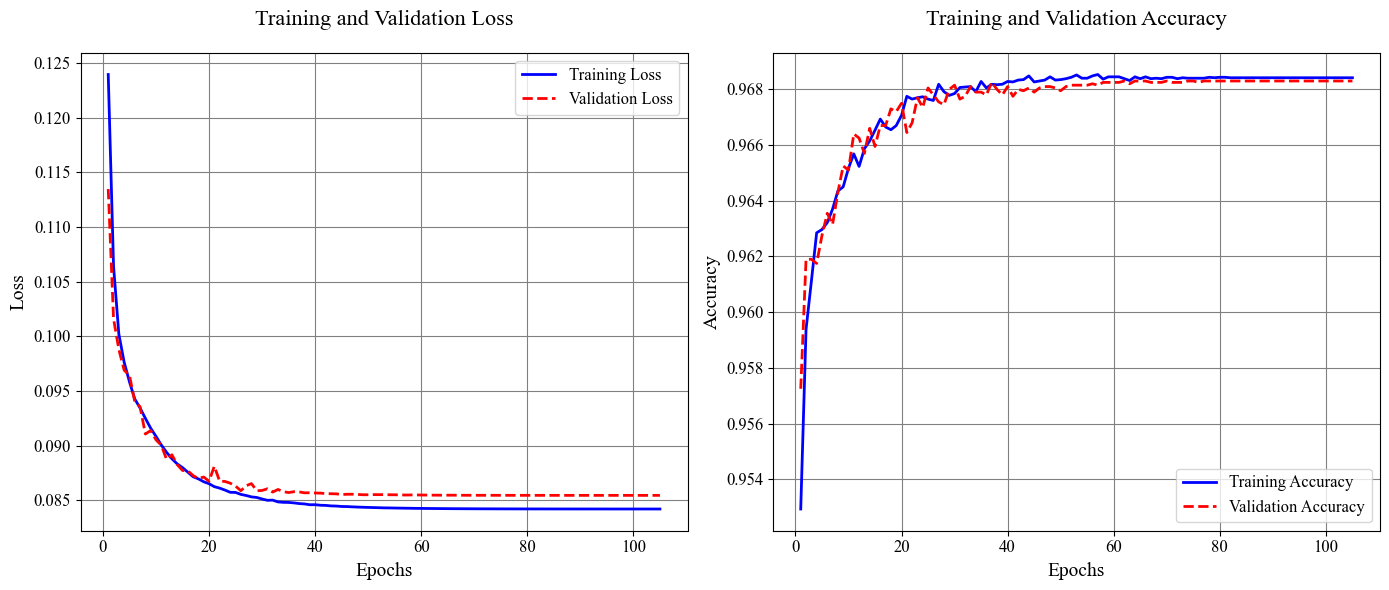

In [99]:
plot_results(history1, 'model1')

This looks better!\
Overfitting has been reduced by LASSO regularization parameter (which was not cross-validated...too much time required)\
Also I could stop the training at epoch 60-70 and not lose any information.

In [104]:
# === Evaluate ===
y_pred = model1.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f"Validation AUC: {auc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation AUC: 0.9934


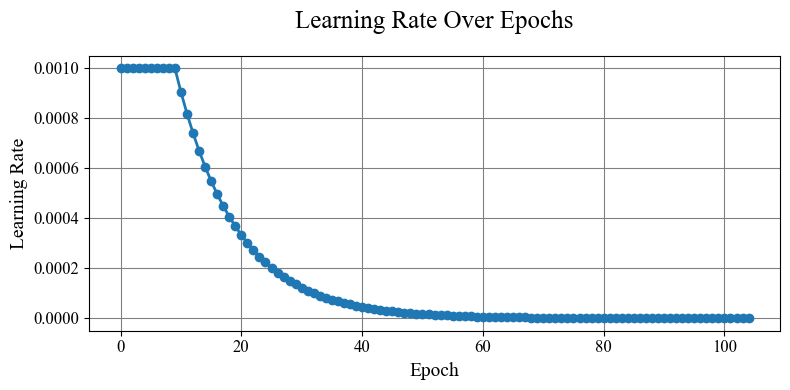

In [105]:
plt.figure(figsize=(8, 4))
plt.plot(lr_tracker1.lrs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Over Epochs')
plt.savefig('lr_model3')

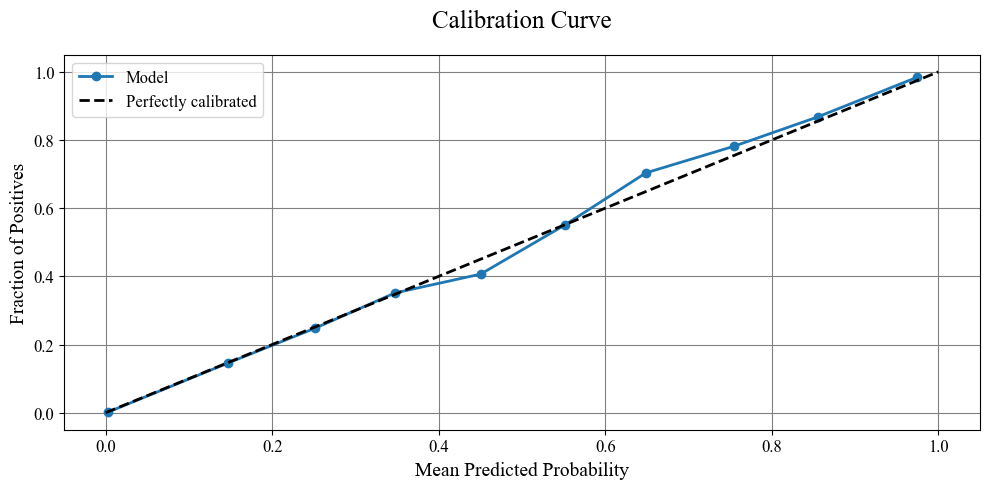

In [106]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()


Calibration curve looks great!\
The model overestimates the fraction of true positives for a mean predicted probability of 45% and underestimates it for a mpp of 60-70%.

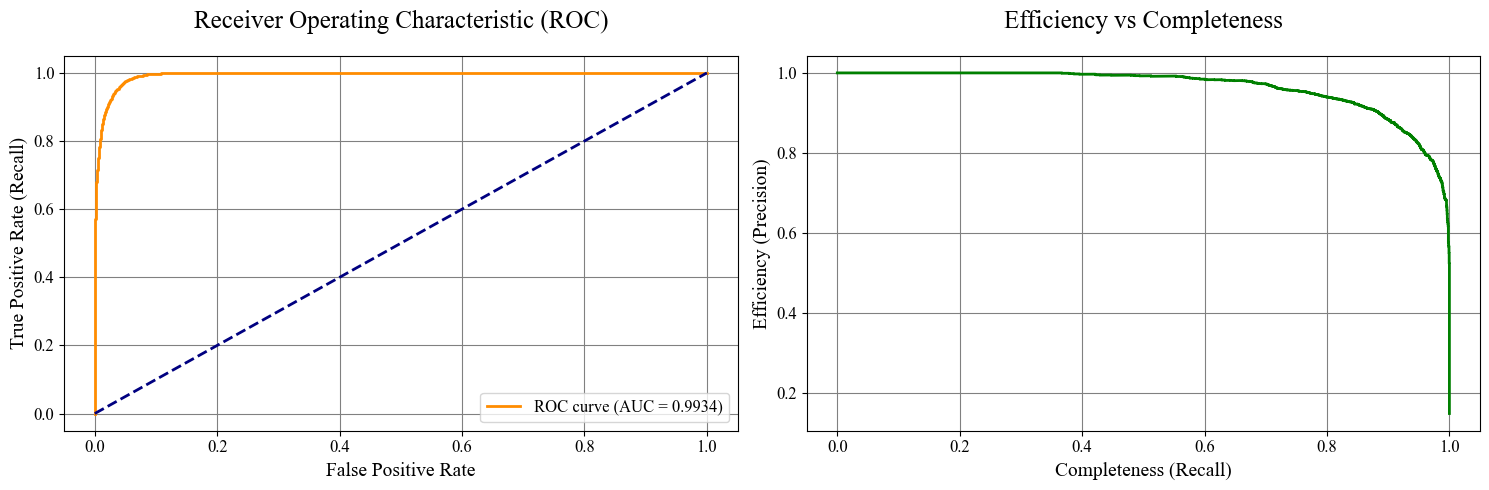

In [117]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Completeness (Recall)')
plt.ylabel('Efficiency (Precision)')
plt.title('Efficiency vs Completeness')
plt.grid(True)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

ROC curve is very good!
In order to get a TPR of 80% I need to accept less then 10% of FPR.\
To get a very complete set of predicted labels I need to accept a loss in efficiency of about 20% which is fine.

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Text(0.5, 1.0, 'Confusion Matrix')

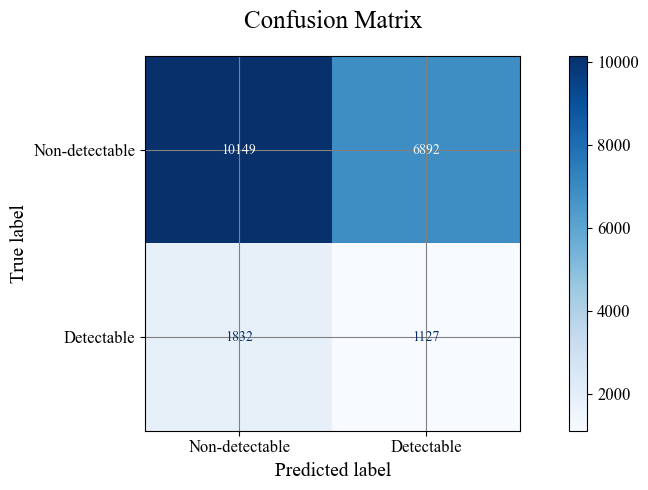

In [118]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict probabilities and apply threshold (default 0.5)
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-detectable", "Detectable"])

# Plot it
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")

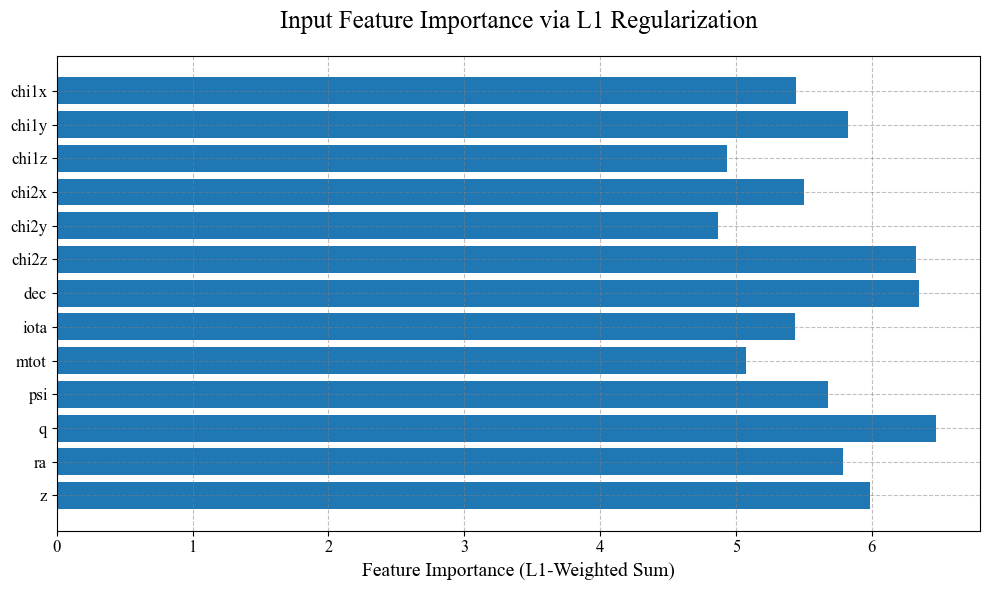

In [131]:
first_layer_weights = model.layers[0].get_weights()[0]  # shape: (13, 32)
feature_importance = np.sum(np.abs(first_layer_weights), axis=1)  # shape: (13,)

# Feature names
feature_names = df.columns.to_list()
# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel("Feature Importance (L1-Weighted Sum)")
plt.title("Input Feature Importance via L1 Regularization")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [110]:
intrinsic_features = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'mtot', 'q', 'z']
extrinsic_features = ['ra', 'dec', 'iota', 'psi']
intrinsic_indices = [df.columns.to_list().index(k) for k in intrinsic_features]
extrinsic_indices = [df.columns.to_list().index(k) for k in extrinsic_features]
intrinsic_sample = X_test[:, intrinsic_indices]
extrinsic_sample = X_test[:, extrinsic_indices]

In [111]:
def marginalized_prediction(model, intrinsic_input, extrinsic_sampler, n_samples=100):
    """
    Computes the marginalized prediction over extrinsic variables.

    Args:
        model: Your trained neural network.
        intrinsic_input: Array of shape (batch_size, 9) with intrinsic features.
        extrinsic_sampler: Function returning (batch_size, 4) samples of extrinsic features.
        n_samples: Number of Monte Carlo samples.

    Returns:
        Marginalized probabilities: Array of shape (batch_size,)
    """
    batch_size = intrinsic_input.shape[0]
    preds = []

    for k in range(n_samples):
        if k%10==0:
            print(k)
        extrinsic_sample = extrinsic_sampler(batch_size)  # shape (batch_size, 4)
        full_input = np.concatenate([intrinsic_input, extrinsic_sample], axis=1)  # shape (batch_size, 13)
        pred = model.predict(full_input)  # shape (batch_size,)
        preds.append(pred)

    preds = np.stack(preds, axis=0)  # shape (n_samples, batch_size)
    return preds.mean(axis=0)

def extrinsic_sampler(batch_size):
    # For example, uniform sampling for 4 extrinsic parameters in given ranges
    return np.random.uniform(low=[-1, -1, -1, -1], high=[1, 1, 1, 1], size=(batch_size, 4))

In [112]:
predictions = marginalized_prediction(model1, intrinsic_sample, extrinsic_sampler)

0
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
625/625 

In [113]:
import pandas as pd

intrinsic_keys = ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'mtot', 'q', 'z']
intrinsic_indices = [np.where(np.array(df.columns.to_list()) == k)[0][0] for k in intrinsic_keys]

dd = S.inverse_transform(X_test)[:, intrinsic_indices]
df = pd.DataFrame(dd, columns=intrinsic_keys)
df['prediction'] = predictions

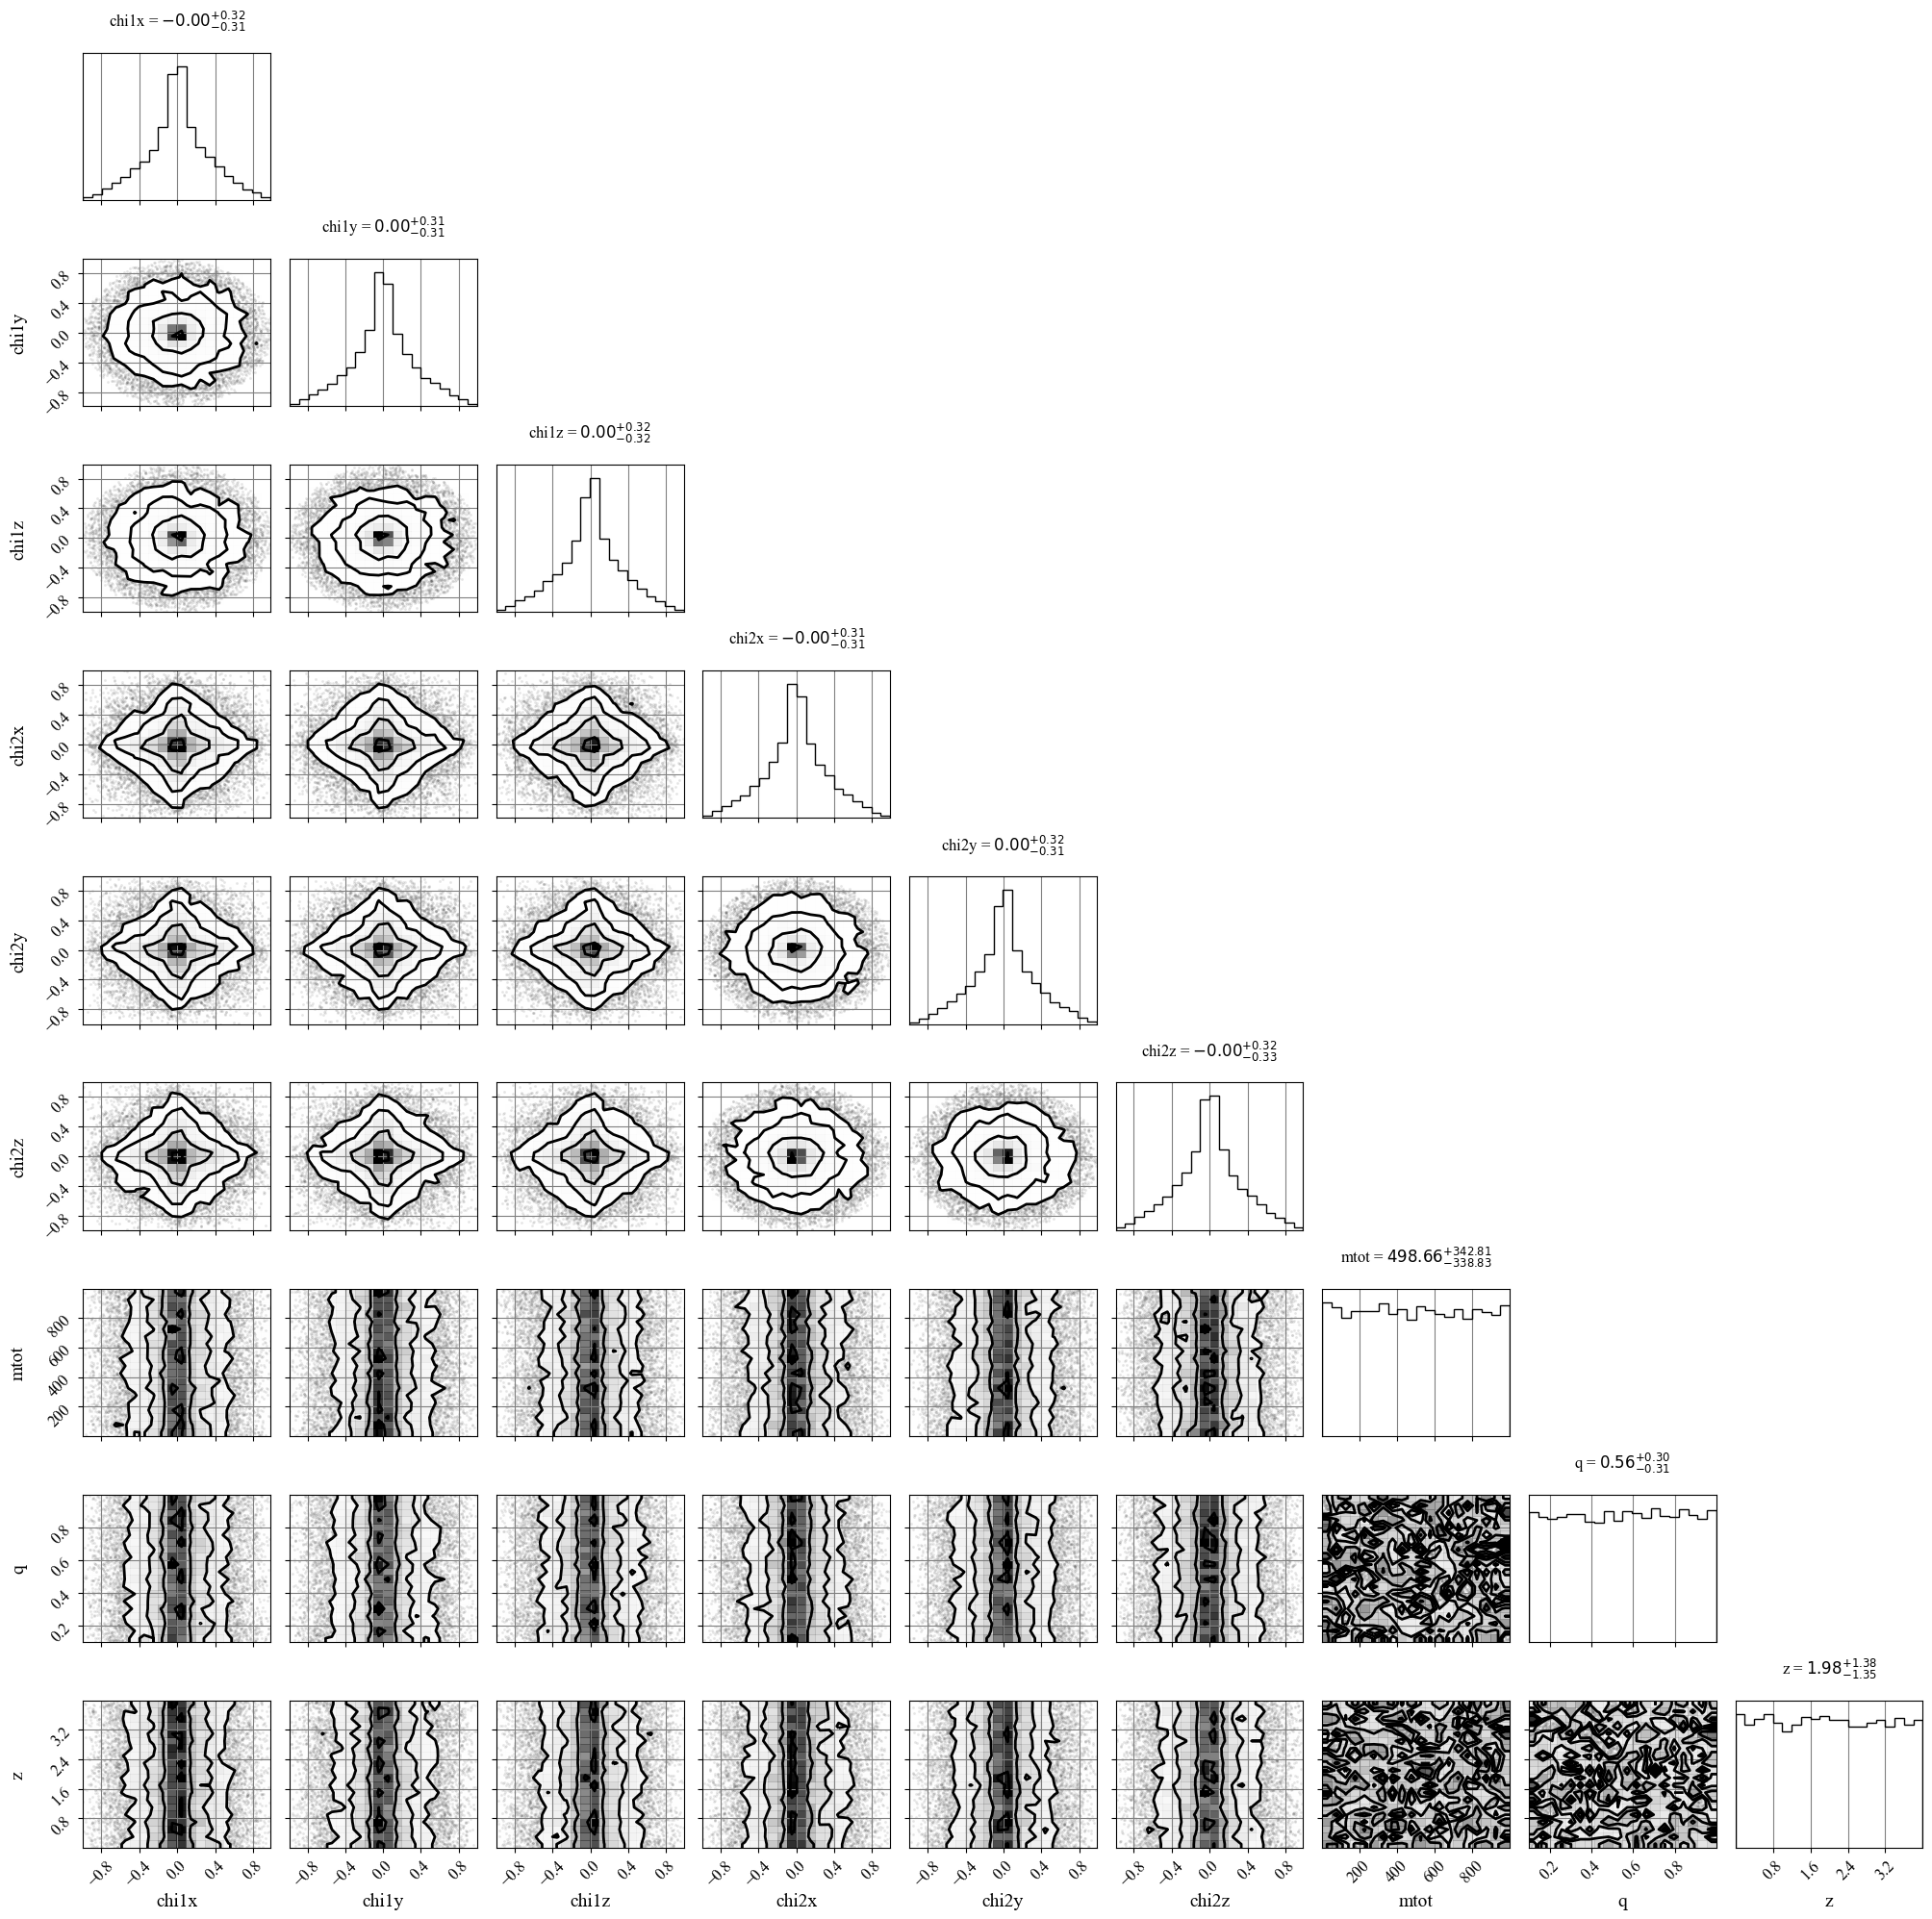

In [114]:
import corner

fig = corner.corner(df[intrinsic_keys], 
                    labels=intrinsic_keys, 
                    plot_contours=True, 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12})

plt.show()